In [7]:
try:
  # We must install required packages if we are in Google Colab
  import google.colab
  %pip install roboticstoolbox-python>=1.0.2
except:
  # We are not in Google Colab
  # Apply custon style to notebook
  from IPython.core.display import HTML
  import pathlib
  styles_path = pathlib.Path(pathlib.Path().absolute(), "style", "style.css")
  styles = open(styles_path, "r").read()
  HTML(f"<style>{styles}</style>")

$\large{\text{Foundations of Kinematics and Algorithms in Robotics}} \\ \large{\text{Module 3: Twists and Trajectories}}$

$\text{By Jesse Haviland and Peter Corke}$

<br>

### Contents

[1.0 What is Position?](#1)  
[2.0 What is Orientation?](#2)  
[3.0 Homogeneous Coordinates](#3)  
[4.0 Pose Graphs](#4)  

In [8]:
# We will do the imports required for this notebook here

# numpy provides import array and linear algebra utilities
import numpy as np

# the robotics toolbox provides robotics specific functionality
import roboticstoolbox as rtb

# spatial math provides objects for representing transformations
import spatialmath as sm
import spatialmath.base as smb

import spatialgeometry as sg

from swift import Swift

# The matrix exponential method
from scipy.linalg import expm, logm

# sympy provides symbolic mathematic operations 
import sympy as sym

# setting up sympy to print nicely
from IPython import display as ds
from sympy.physics.mechanics import init_vprinting
from sympy.physics.vector import vlatex
init_vprinting(use_latex='mathjax')

<br>

<a id='2'></a>
# 1.0 Twists
---

Earlier, we discussed the concept of Lie groups and we explained how we can get an $\mathbf{SO}(3)$ from the angle-axis representation:

Given the angle axis representation where
$$
    \hat{\mathbf{\eta}} = \begin{pmatrix}
        \hat{\eta}_1 \\
        \hat{\eta}_2 \\
        \hat{\eta}_3
    \end{pmatrix}
$$

defines the axis of rotation, and $\theta$ is the angle of rotation, we can get the Euler vector (also known as the exponential coordinates) by

\begin{equation*}
    \bf{\eta} =
    \hat{\eta} \ \theta \in \mathbb{R}^3
\end{equation*}

and we can turn the Euler vector into an $\mathbf{so}(3)$ matrix (the Lie algebra of the $\mathbf{SO}(3)$ group) through the `skew` operation

$$
    [\mathbf{\eta}]_\times =
    \begin{pmatrix}
        0 & -\eta_3 & \eta_2 \\
        \eta_3 & 0 & -\eta_1 \\
        -\eta_2 & \eta_1 & 0
    \end{pmatrix} \in \mathbf{so}(3).
$$

Finally, we can construct the $\mathbf{SO}(3)$ matrix from the $\mathbf{so}(3)$ matrix using the matrix exponential

$$
    \mathbf{R}(\mathbf{\eta}) = e^{[\mathbf{\eta}]_\times} \in \mathbf{SO}(3).
$$

We can also follow this process with a vector $\mathbf{s} \in \mathbb{R}^6$ to get an $\mathbf{SE}(3)$ matrix. Through the vector $\mathbf{s}$, we can define a pose (translation and rotation).

## Representing Pose as a Twist

We can represent pose as a twist

$$
    \mathbf{s} =
    \begin{pmatrix}
        \upsilon_1 \\
        \upsilon_2 \\
        \upsilon_3 \\
        \eta_1 \\
        \eta_2 \\
        \eta_3
    \end{pmatrix}
    \in \mathbb{R}^6
$$

where the first three elements $\mathbf{\upsilon}$ define the translation and the last three elements $\mathbf{\eta}$ define the rotation.

_Note that we are using the Greek letter upsilon $\upsilon$ (not to be confused with the English letter $v$ or the Greek letter nu $\nu$) to represent the translation component._



We can convert a twist into an augmented skew symmetric matrix (the Lie algebra of the $\mathbf{SE}(3)$ group) using the `skewa` operation

$$
    [\mathbf{s}] =
    \begin{pmatrix}
        0 & -\eta_3 & \eta_2 & \upsilon_1 \\
        \eta_3 & 0 & -\eta_1 & \upsilon_2 \\
        -\eta_2 & \eta_1 & 0 & \upsilon_3 \\
        0 & 0 & 0 & 0
    \end{pmatrix} \in \mathbf{se}(3).
$$

and we can convert this matrix into an $\mathbf{SE}(3)$ matrix using the matrix exponential

$$
    \mathbf{T}(\mathbf{s}) = e^{[\mathbf{s}]} \in \mathbf{SE}(3).
$$

## The Zero Twist

What happens if we make a twist with all zeros?

$$
    \mathbf{s} =
    \begin{pmatrix}
        0 \\
        0 \\
        0 \\
        0 \\
        0 \\
        0
    \end{pmatrix}
$$

We can convert this into an augmented skew symmetric matrix

$$
    [\mathbf{s}] =
    \begin{pmatrix}
        0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0
    \end{pmatrix}
$$

and we can convert this matrix into an $\mathbf{SE}(3)$ matrix using the matrix exponential

\begin{align*}
    \mathbf{T}(\mathbf{s})
    &= e^{[\mathbf{s}]} \\
    &=
    \begin{pmatrix}
        1 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 \\
        0 & 0 & 1 & 0 \\
        0 & 0 & 0 & 1
    \end{pmatrix} 
\end{align*}

which gives us the identity matrix.


## Rotation only Twist

What happens if we make a twist around the $z$-axis and no translation component?

$$
    \mathbf{s}(\theta) =
    \begin{pmatrix}
        0 \\
        0 \\
        0 \\
        0 \\
        0 \\
        \theta
    \end{pmatrix}
$$

We can convert this into an augmented skew symmetric matrix

$$
    [\mathbf{s}(\theta)] =
    \begin{pmatrix}
        0 & -\theta & 0 & 0 \\
        \theta & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0
    \end{pmatrix}
$$

and we can convert this matrix into an $\mathbf{SE}(3)$ matrix using the matrix exponential

\begin{align*}
    \mathbf{T}(\theta)
    &= e^{[\mathbf{s}(\theta)]} \\
    &=
    \begin{pmatrix}
        \cos(\theta) & -\sin(\theta) & 0 & 0 \\
        \sin(\theta) & \cos(\theta) & 0 & 0 \\
        0 & 0 & 1 & 0 \\
        0 & 0 & 0 & 1
    \end{pmatrix}
\end{align*}



And we can see this is just a rotation matrix around the $z$-axis embedded in an $\mathbf{SE}(3)$ matrix.

## Translation only Twist

What happens if we make a twist with no rotation component and a translation component?

$$
    \mathbf{s}(\upsilon) =
    \begin{pmatrix}
        \upsilon_1 \\
        \upsilon_2 \\
        \upsilon_3 \\
        0 \\
        0 \\
        0
    \end{pmatrix}
$$

We can convert this into an augmented skew symmetric matrix

$$
    [\mathbf{s}(\upsilon)] =
    \begin{pmatrix}
        0 & 0 & 0 & \upsilon_1 \\
        0 & 0 & 0 & \upsilon_2 \\
        0 & 0 & 0 & \upsilon_3 \\
        0 & 0 & 0 & 0
    \end{pmatrix}
$$

and we can convert this matrix into an $\mathbf{SE}(3)$ matrix using the matrix exponential

\begin{align*}
    \mathbf{T}(\upsilon)
    &= e^{[\mathbf{s}(\upsilon)]} \\
    &=
    \begin{pmatrix}
        1 & 0 & 0 & \upsilon_1 \\
        0 & 1 & 0 & \upsilon_2 \\
        0 & 0 & 1 & \upsilon_3 \\
        0 & 0 & 0 & 1
    \end{pmatrix}
\end{align*}



For the case where there is no rotation, the translation component of the twist $\mathbf{\upsilon}$ to the translation component $\mathbf{t}$ of the $\mathbf{SE}(3)$ matrix.

In [9]:
x = sym.Symbol('x')
y = sym.Symbol('y')
z = sym.Symbol('\\theta')

# s = np.array([
#     [0, -z, x],
#     [z, 0, y],
#     [0, 0, 0]
# ])

# t = sym.simplify(sym.Matrix(s).exp())

# ds.display(ds.Math(f"exp(s) = {sym.latex(sym.simplify(t))}"))


theta = 1.0
s = np.array([
    [0, -theta, 1.0],
    [theta, 0, 2.0],
    [0, 0, 0]
])

t = expm(s)

# ds.display(ds.Math(f"exp(s) = {sym.latex(sym.simplify(t))}"))

print(np.round(t, 3))

print(np.linalg.norm(t[:2, -1]))
print(np.linalg.norm(s[:2, -1]))

[[ 0.54  -0.841 -0.078]
 [ 0.841  0.54   2.143]
 [ 0.     0.     1.   ]]
2.144056188936895
2.23606797749979


In [10]:
a = sym.Symbol('a')

g = np.array([[0, -1], [1, 0]])

g_theta = sym.Matrix(a * g)

ds.display(ds.Math(f"g_{{\\theta}} = {sym.latex(g_theta)}"))

r = sym.simplify(sym.Matrix(a * g).exp())

ds.display(ds.Math(f"R = {sym.latex(sym.Matrix(r))}"))

dr = sym.diff(r, a)

ds.display(ds.Math(f"dR = {sym.latex(sym.Matrix(dr))}"))

theta = np.pi/4

dr_eye = sym.simplify(dr.subs(a, theta)).evalf()

ds.display(ds.Math(f"dR(\\theta={theta}) = {sym.latex(sym.Matrix(dr_eye))}"))

r_eval = sym.simplify(r.subs(a, theta)).evalf()

ds.display(ds.Math(f"R(\\theta={theta}) = {sym.latex(sym.Matrix(r_eval))}"))

what = dr_eye @ r_eval.T

ds.display(ds.Math(f"{{\\omega}} = {sym.latex(sym.Matrix(what))}"))

ds.display(ds.Math(f"\\eta = {sym.latex(sym.Matrix(np.round(logm(np.array(r_eval, dtype=np.float64)), 2)))}"))


# rs = sym.Matrix(sm.SO2(a).A)

# print(rs)

# drs = sym.diff(rs, a)

# print(drs)



# print(drs.subs(a, 1.5))



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [11]:
s = sm.Twist3([1, 2, 4, 0, 0, 30])

print(s)

print(s.exp())

print(s.pole)


(1 2 4; 0 0 30)
   0.1543    0.988     0        -0.08932   
  -0.988     0.1543    0        -0.03768   
   0         0         1         4         
   0         0         0         1         

[-2.  1.  0.]


In [12]:
x, y, z = sym.symbols('x y z')

t = np.array([x, y, z])

a = np.array([0.041, 0.408, 0.789])
theta = np.linalg.norm(a)
ahat = a/theta

print(ahat)

print(theta)

askew = smb.skew(ahat)

print(askew @ t)

[0.04610917 0.45884249 0.88732041]
0.8891940170738892
[-0.887320410225429*y + 0.458842493500602*z
 0.887320410225429*x - 0.0461091721409918*z
 -0.458842493500602*x + 0.0461091721409918*y]


<br>

<a id='2'></a>
# 2.0 Trajectories
---

We wish to make trajectories in the context of __robotics__. This means that we have boundary conditions. The boundary conditions are that at time $t=0$ we have a set pose, orientation, or position and at time $t=T$ we have a desired pose, orientation, or position.

Additionally, real-world bound constraints exist. For example, a drone, car, or manipulator cannot instantly _step_ in velocity, to do so would require infinite acceleration. Therefore we may define another boundary condition that the initial and final velocity is zero and we wish for a smooth velocity profile.

## 2.1 Smooth One-Dimensional Trajectory

### Polynomial Trajectory

We start our discussion with a scalar function of time that has a
specified initial and final value.
An obvious candidate for such a smooth function is a polynomial
function of time. Polynomials are
simple to compute and can easily provide the required smoothness and boundary conditions. A quintic
(fifth-order) polynomial is commonly used

$$
	q(t)=At^{5}+Bt^{4}+Ct^{3}+Dt^{2}+Et+F
$$

where time $t\in [0,T]$. The first- and second-derivatives are also polynomials

\begin{align*}
	\dot{q}(t)  &= 5At^{4}+4Bt^{3}+3Ct^{2}+2Dt+E \\
	\ddot{q}(t) &= 20At^{3}+12Bt^{2}+6Ct+2D
\end{align*}

and therefore smooth. The third-derivative, jerk, will be a quadratic.

The trajectory has defined boundary conditions for position ($q_0$, $q_T$), velocity ($\dot{q}_0$, $\dot{q}_T$) and
acceleration ($\ddot{q}_0$, $\ddot{q}_T$).
Writing $q(t)$ to $\ddot{q}(t)$ for the boundary conditions $t=0$ and $t=T$ gives six
equations which we can write in matrix form as

$$
	\left(\begin{array}{c}
		q_{0}\cr
		q_{T}\cr
		\dot{q}_{0}\cr
		\dot{q}_{T}\cr
		\ddot{q}_{0}\cr
		\ddot{q}_{T}
	\end{array}\right)%þ
	=\begin{pmatrix}
		0       & 0       & 0      & 0     & 0 & 1\cr
		T^{5}   & T^{4}   & T^{3}  & T^{2} & T & 1\cr
		0       & 0       & 0      & 0     & 1 & 0\cr
		5T^{4}  & 4T^{3}  & 3T^{2} & 2T    & 1 & 0\cr
		0       & 0       & 0      & 2     & 0 & 0\cr
		20T^{3} & 12T^{2} & 6T     & 2     & 0 & 0
	\end{pmatrix}
	\left(\begin{array}{c}
		A\cr
		B\cr
		C\cr
		D\cr
		E\cr
		F
	\end{array}\right)  \,\,.
$$

The matrix is square and, if $T \ne 0$, we can invert it to solve for the coefficient vector $(A, B, C, D, E, F)$.

_This is the reason for choice of quintic polynomial. It has six coefficients that enable it to meet the six boundary conditions on initial and final position, velocity and acceleration._

The Toolbox provides a function to generate the trajectory described above

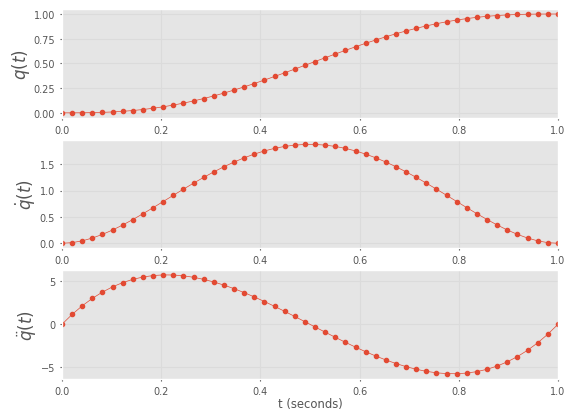

In [13]:
# The initial position
q0 = 0.0

# The final position
qf = 1.0

# The start time
t0 = 0.0

# The end time
tf = 1.0

# A vector for time
# Steps from t0 to tf in 50 steps
t = np.linspace(t0, tf, 50)

# Create the trajectory
traj = rtb.quintic(q0, qf, t)

# Plot the trajectory
traj.plot()

In [65]:
# Animate the trajectory
env = Swift()
env.launch(browser='notebook', realtime=True)
obj = sg.Sphere(0.03, color="#fc0349")
env.add(obj)
env.set_camera_pose([0.5, 1.0, 0.5], [0.5, 0.0, 0.0])

for q in traj.q:
    obj.T = sm.SE3.Tx(q)
    env.step(0.02)

We can see in the above Figure that the initial position, velocity and acceleration are 0, the final position is 1, and the final velocity and acceleration are 0. These are our boundary conditions. Adjust the variables in the code above and see how the trajectory changes.

We can access the position, velocity, acceleration vectors using `traj.q`, `traj.qd`, `traj.qdd` respectively.

In [14]:
print("The position vector, rounded to 3 decimal places, is")
print(np.round(traj.q, 3))


The position vector, rounded to 3 decimal places, is
[-0.     0.     0.001  0.002  0.005  0.009  0.015  0.023  0.034  0.046
  0.061  0.078  0.098  0.12   0.145  0.171  0.2    0.23   0.263  0.297
  0.332  0.368  0.405  0.443  0.481  0.519  0.557  0.595  0.632  0.668
  0.703  0.737  0.77   0.8    0.829  0.855  0.88   0.902  0.922  0.939
  0.954  0.966  0.977  0.985  0.991  0.995  0.998  0.999  1.     1.   ]


We can set the desired initial final velocity by providing extra keyword arguments to the `traj` function.

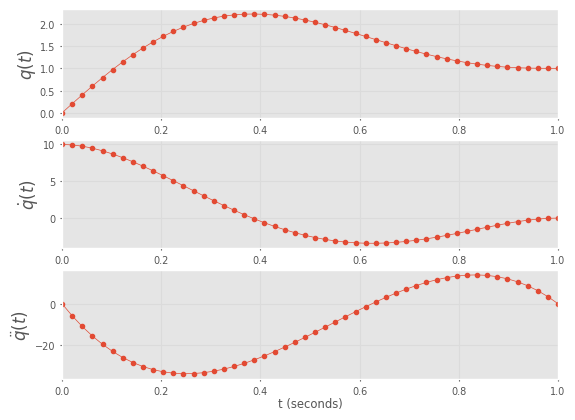

In [15]:
# The initial position
q0 = 0.0

# The final position
qf = 1.0

# The start time
t0 = 0.0

# The end time
tf = 1.0

# The initial velocity
qd0 = 10.0

# The final velocity
qdf = 0.0

# A vector for time
# Steps from t0 to tf in 50 steps
t = np.linspace(t0, tf, 50)

# Create the trajectory
traj2 = rtb.quintic(q0, qf, t, qd0, qdf)

# Plot the trajectory
traj2.plot()

In [64]:
# Animate the trajectory
env = Swift()
env.launch(browser='notebook', realtime=True)
obj = sg.Sphere(0.03, color="#fc0349")
env.add(obj)
env.set_camera_pose([1.1, 1.0, 0.5], [1.1, 0.0, 0.0])

for q in traj2.q:
    obj.T = sm.SE3.Tx(q)
    env.step(0.02)

This illustrates an important problem with polynomials – non zero initial velocity causes the polynomial to overshoot the terminal value, in this example, peaking at over 2 on a trajectory from 0 to 1.

Another problem with polynomials, a very practical one, can be seen in the middle graph of our first `traj` plot. The velocity peaks when $t = 0.5$ s which means that, for most of the time, the velocity is far less than the maximum. The mean velocity

In [16]:
qd = traj.qd

qd.mean() / qd.max()


0.523102222222221

is only 52.3% of the peak so we are not using the motor as fully as we could. A real robot joint has a well-defined maximum speed and, for minimum-time motion, we want to be operating at that maximum for as much of the time as possible. We would like the velocity curve to be _flatter_ on top.

### Trapezoidal Hybrid Trajectory

A well known alternative to polynomials is a _trapezoidal_ hybrid trajectory

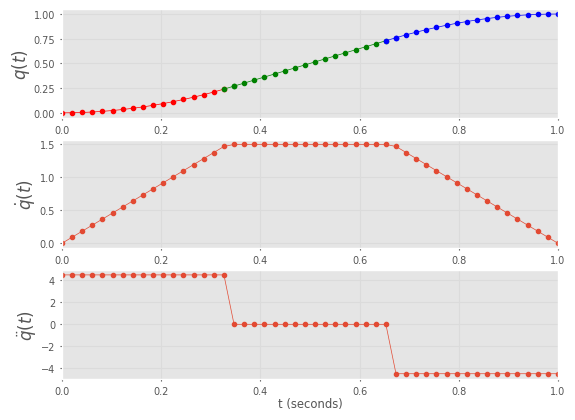

In [17]:
# The initial position
q0 = 0.0

# The final position
qf = 1.0

# The start time
t0 = 0.0

# The end time
tf = 1.0

# A vector for time
# Steps from t0 to tf in 50 steps
t = np.linspace(t0, tf, 50)

# Create the trajectory
traj3 = rtb.trapezoidal(q0, qf, t)

# Plot the trajectory
traj3.plot()

In [63]:
# Animate the trajectory
env = Swift()
env.launch(browser='notebook', realtime=True)
obj0 = sg.Sphere(0.03, color="#008cff")
obj1 = sg.Sphere(0.03, color="#fc0349")
env.add(obj0)
env.add(obj1)
env.set_camera_pose([0.5, 1.0, 0.5], [0.5, 0.0, 0.0])

for q0, q1 in zip(traj.q, traj3.q):
    obj0.T = sm.SE3.Tx(q0)
    obj1.T = sm.SE3.Tx(q1)
    env.step(0.02)


The animation above shows a comparison of the polynomial and trapezoidal profiles. The red sphere is trapezoidal and the blue sphere is polynomial.

The velocity trajectory has a trapezoidal shape, hence the name, comprising three linear segments. The corresponding segments of the position trajectory are a straight line (constant velocity segment) with parabolic blends. The term blend refers to a trajectory segment that smoothly joins linear segments. This type of trajectory is commonly used in industrial motor drives. It is continuous in position and velocity, but not in acceleration.

The function `trapezoidal` has chosen the velocity of the linear segment to be

In [19]:
traj3.qd.max()

1.5

but this can be overridden by specifying an additional argument

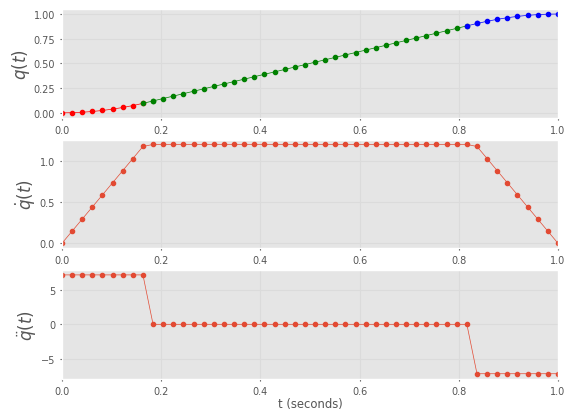

In [20]:
# Set the maximum velocity to 1.2
v_max = 1.2

traj4 = rtb.trapezoidal(q0, qf, t, V=v_max)
traj4.plot()

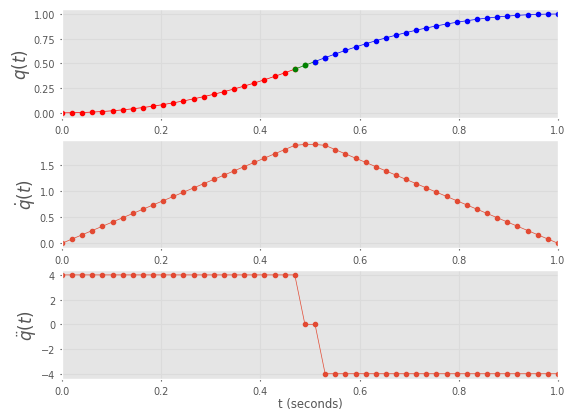

In [21]:
# Set the maximum velocity to 1.9
v_max = 1.9

traj5 = rtb.trapezoidal(q0, qf, t, V=v_max)
traj5.plot()

We see that as the velocity of the linear segment increases, its duration decreases and ultimately its duration would be zero. In fact, the velocity cannot be chosen arbitrarily – too high or too low a value for the maximum velocity will result in an infeasible trajectory and the function will return an error

### Interpolate Simple Translations and Rotations

From what we have learned so far, we start to interpolate single parameter positions and orientations.

For a 2D orientation, we can describe the rotation angle using a single number $\theta(t)$. We can interpolate the rotation angle using a polynomial or trapezoidal trajectory.

In the following example we will interpolate between a starting angle $\theta(0) = 15^\circ$ and a final angle $\theta(1.0) = 120^\circ$, where we wish the final angle to occur at time $t = 1$ s.

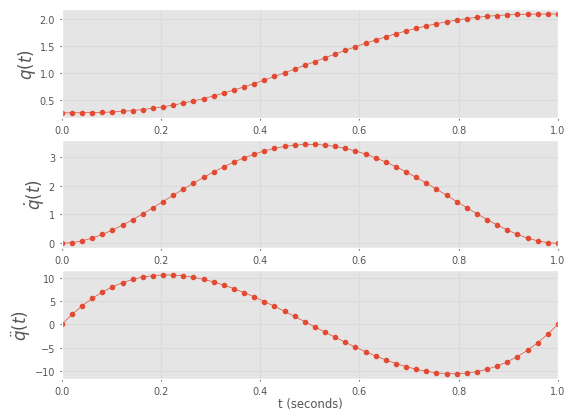

In [72]:
# Our inital and final angles in radians
theta0 = 15 * np.pi / 180
thetaf = 120 * np.pi / 180

# The start and finish time
t0 = 0.0
tf = 1.0

# A vector for time
# Steps from t0 to tf in 50 steps
t = np.linspace(t0, tf, 50)

# Create the trajectory/interpolate between the two angles
traj6 = rtb.quintic(theta0, thetaf, t)

# Plot the trajectory
traj6.plot()


In [125]:
# Animate the trajectory
env = Swift()
env.launch(browser='notebook', realtime=True)
obj = sg.Arrow(0.2, 0.005, 0.2, 0.2, color="#fc0349")
env.add(obj)

env.set_camera_pose([0.0, 0.0, 0.5], [0.0, 0.0, 0.0])

for q in traj6.q:
    obj.T = sm.SE3.Rx(np.pi / 2) * sm.SE3.Ry(np.pi / 2) * sm.SE3.Ry(q)
    env.step(0.02)

## Test your Understanding

#### Question 1

Convert the trajectory calculated in `traj6` above to a vector of $\mathbf{SO}(2)$ objects using the `spatialmath` class `SO2`.

#### Question 2

Plot the interpolated coordinate frames from Question 1 using `SO2` plot methods.

#### Question 3

For interpolating orientations, would you prefer to use a polynomial or trapezoidal trajectory? Why?

#### Question 4

What are some other robotics applications for trajectories?

## 2.2 Multi-Axis Trajectory

Most useful robots have more than one axis of motion and it is quite straightforward to extend the smooth scalar trajectory to the vector case. In terms
of configuration space, these axes of motion correspond to the dimensions of the robot's configuration space -- to its degrees of
freedom. We represent the robot's configuration as a vector $\mathbf{q}\in	{\mathbb{R}}^{n}$ where $n$ is the number of degrees of freedom. The configuration of a 3-joint
robot would be its joint coordinates $\mathbf{q}=(q_{0}, q_{1}, q_{2})$. The configuration vector of wheeled mobile robot might be its position $\mathbf{q}=(x, \ y$) or its position and heading angle $\mathbf{q}=(x,y,\theta)$. For a 3-dimensional body that had an orientation in $\mathbf{SO}(3)$ we
would use roll-pitch-yaw angles $\mathbf{q}=(\alpha, \beta, \gamma)$, or for a pose in $\mathbf{SE}(3)$ we would use
$\mathbf{q}=(x,y,z, \alpha, \beta, \gamma)$. 

_For orientation, any 3-parameter representation could be used: roll-pitch-yaw angles, Euler angles or exponential coordinates._

In all these cases, we would require smooth multi-dimensional motion from an initial configuration vector to a final configuration vector.

Consider a 2-axis $xy$-type robot moving from configuration $(0,2)$ to $(1, -1)$ in 50 steps with a trapezoidal profile. 

Using the Toolbox, this is achieved using the function `mtraj` and we write

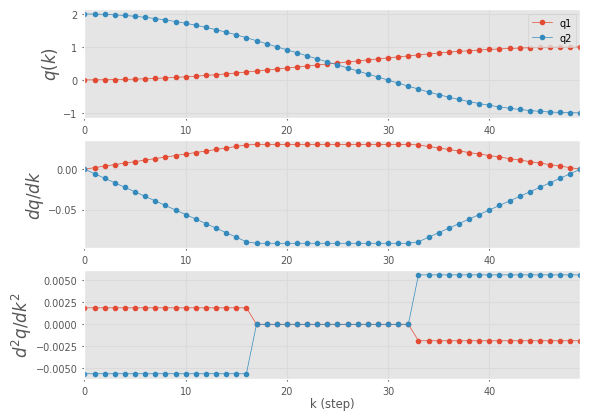

In [23]:
# The initial position as a vector
q0 = [0, 2]

# The final position as a vector
qf = [1, -1]

# The number of steps
steps = 50

# Create the trajectory
traj7 = rtb.mtraj(rtb.trapezoidal, q0, qf, steps)

# Plot the trajectory
traj7.plot()

In [126]:
# Animate the trajectory
env = Swift()
env.launch(browser='notebook', realtime=True)
obj0 = sg.Sphere(0.03, color="#008cff")
obj1 = sg.Sphere(0.03, color="#fc0349")
env.add(obj0)
env.add(obj1)
env.set_camera_pose([0.5, 2.0, 0.5], [0.5, 0.0, 0.0])

for q0, q1 in zip(traj7.q[:, 0], traj7.q[:, 1]):
    obj0.T = sm.SE3.Tx(q0)
    obj1.T = sm.SE3.Tx(q1)
    env.step(0.02)

The attribute `traj7.q` is a matrix with 50 rows and 2 columns, each row being the configuration at a particular time step. Note that we could have used `rtb.quintic` as the first argument to `mtraj` to generate a quintic polynomial trajectory.

<br>

<a id='3'></a>
# 3.0 Interpolation of Orientation
---

In robotics, we often need to interpolate orientation. This essentially means that we wish to smoothly transition from one orientation to another and to achieve this we create a sequence of orientations that smoothly approach the desired orientation while starting at the original.

More specifically, given two orientations ${^0\mathbf{R}_a}$ and ${^a\mathbf{R}_b}$, we require a function $f(s) = \sigma({^0\mathbf{R}_a}, {^a\mathbf{R}_b}, s)$ where $s \in [0, 1]$ and we have boundary conditions that give $f(0) = {^0\mathbf{R}_a}$ and $f(1) = {^0\mathbf{R}_b}$. The function must vary _smoothly_ for intermediate values of $s$.

## Interpolation using RPY Angles

A simple approach to interpolation is to convert or rotations to roll-pitch-yaw angles, $\Gamma \in (\mathbf{S^1})^3$ and use linear interpolation

$$
    \sigma(\Gamma_0, \ \Gamma_1, \ s) = (1 - s) \Gamma_0 + s \Gamma_1
$$

where $s \in [0, 1]$. We can then convert the interpolated roll-pitch-yaw angles back to a rotation matrix.

<IPython.core.display.Math object>

<IPython.core.display.Math object>

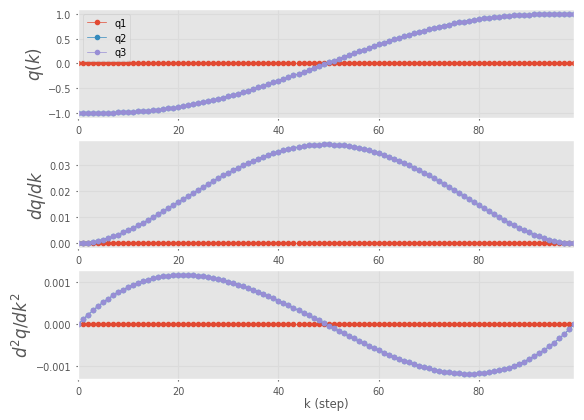

In [90]:
R0 = sm.SO3.Rz(-1) * sm.SO3.Ry(-1)
R1 = sm.SO3.Rz(1) * sm.SO3.Ry(1)

rpy0 = np.expand_dims(R0.rpy(), axis=1)
rpy1 = np.expand_dims(R1.rpy(), axis=1)

ds.display(ds.Math(f"R_0 = {sym.latex(sym.Matrix(np.round(R0.A, 2)))}"))
ds.display(ds.Math(f"R_1 = {sym.latex(sym.Matrix(np.round(R1.A, 2)))}"))

traj8 = rtb.mtraj(rtb.quintic, rpy0, rpy1, 100)

traj8.plot()

We have a sequence of 100 RPY angles. Let's convert them back to orientation matrices.

In [91]:
# Convert the list of RPY angles to a list of SO3 objects
pose = sm.SO3.RPY(traj8.q)

# Animate the trajectory
env = Swift()
env.launch(browser='notebook', realtime=True)
obj = sg.Axes(0.1)
env.add(obj)

env.set_camera_pose([0.5, 0.3, 0.3], [0.0, 0.0, 0.0])

for R in pose:

    # Move axes into free space to visualise it more clearly, then rotate
    obj.T = sm.SE3.Trans(0.2, 0.2, 0.2) * sm.SE3(R)
    env.step(0.02)

For large orientation change we see that the axis, around which the coordinate frame rotates, changes along the trajectory. The motion, while smooth, can look a bit uncoordinated. There will also be problems if either $\mathbf{R}_1$ or $\mathbf{R}_2$ is close to a singularity in the particular vector representation of orientation.

Interpolation of unit quaternions is only a little more complex than for 3-angle vectors and results in a rotation about a fixed axis in space. Using the Toolbox, we first ﬁnd the two equivalent unit quaternions

In [92]:
q0 = sm.UnitQuaternion(R0)
q1 = sm.UnitQuaternion(R1)

and then interpolate them in 100 uniform steps

In [99]:
qtraj = q0.interp(q1, 100)
len(qtraj)

print(qtraj[0].A)

[ 0.77015115 -0.22984885 -0.42073549 -0.42073549]


where the object is the initial orientation and the arguments to the `interp` method are the final orientation and the number of steps. The result is a UnitQuaternion object that holds 50 values, which we can animate by

In [121]:
# Convert the list of quaternions to a list of SE3 objects
pose = [q.SE3() for q in qtraj]

# Animate the trajectory
env = Swift()
env.launch(browser='notebook', realtime=True)
obj = sg.Axes(0.1)
env.add(obj)

env.set_camera_pose([0.5, 0.3, 0.3], [0.0, 0.0, 0.0])

for T in pose:
    # Move axes into free space to visualise it more clearly, then rotate
    obj.T = sm.SE3.Trans(0.2, 0.2, 0.2) * T
    env.step(0.02)

Quaternion interpolation is achieved using spherical linear interpolation (`slerp`) in which the unit quaternions follow a great circle 9 path on a 4-dimensional hypersphere. The result in three dimensions is rotation about a fixed axis in space.

When moving between two points on a circle, we can travel clockwise or counter-clockwise – the result is the same but the distance travelled may be different. The same choices exist when we move on a great circle. In this example, we animate a rotation about the $z$-axis, from an angle of $+2$ radians to $-2$ radians

In [122]:
q0 = sm.UnitQuaternion.Rz(-2)
q1 = sm.UnitQuaternion.Rz(2)

qtraj2 = q0.interp(q1, 100)

# Convert the list of quaternions to a list of SE3 objects
pose = [q.SE3() for q in qtraj2]

# Animate the trajectory
env = Swift()
env.launch(browser='notebook', realtime=True)
obj = sg.Axes(0.1)
env.add(obj)

env.set_camera_pose([0.5, 0.3, 0.3], [0.0, 0.0, 0.0])

for T in pose:
    # Move axes into free space to visualise it more clearly, then rotate
    obj.T = sm.SE3.Trans(0.2, 0.2, 0.2) * T
    env.step(0.02)

which is a path that takes the long way around the circle, moving 4 radians when we could travel just $2 \pi - 4 \approx 2.28$ radians in the opposite direction. We can request that the shortest path be taken

In [124]:
qtraj3 = q0.interp(q1, 50, shortest=True)


qtraj2 = q0.interp(q1, 100)

# Convert the list of quaternions to a list of SE3 objects
pose = [q.SE3() for q in qtraj3]

# Animate the trajectory
env = Swift()
env.launch(browser='notebook', realtime=True)
obj = sg.Axes(0.1)
env.add(obj)

env.set_camera_pose([0.5, 0.3, 0.3], [0.0, 0.0, 0.0])

for T in pose:
    # Move axes into free space to visualise it more clearly, then rotate
    obj.T = sm.SE3.Trans(0.2, 0.2, 0.2) * T
    env.step(0.02)

and the animation clearly shows the difference.

## Test Your Understanding

#### Question 1

Can we linearly interpolate using $\mathbf{SO}(3)$ matrices? Why or why not?

#### Question 2

Given two orientations $\mathbf{R}_1 = \mathbf{R}_x(30^\circ)$ and $\mathbf{R}_2 = \mathbf{R}_z(60^\circ)$, interpolate between the two using

* ZXY RPY representation
* XYX Euler angles
* Unit Quaternions
* Euler vector representation

Animate the resulting trajectories and reflect on what changes between the angular representations.

<br>

<a id='4'></a>
# 4.0 Interpolation of Pose
---

Another common requirement in robotics is to ﬁnd a smooth path between two 3D poses in $\mathbf{R}^3 \times \mathbf{S}^3$ which involves change in position as well as in orientation. In robotics, this is often referred to as Cartesian motion. We represent the initial and final poses as $\mathbf{SE}(3)$ matrices

In [127]:
T0 = sm.SE3.Trans([0.4, 0.2, 0]) * sm.SE3.RPY(0, 0, 3)
T1 = sm.SE3.Trans([-0.4, -0.2, 0.3]) * sm.SE3.RPY(-np.pi/4, np.pi/4, -np.pi/2)


The `SE3` object has a method `interp` that interpolates between two poses for normalised distance $s \in [0, 1]$ along the path, for example the midway pose between `T_0` and `T_1` is

In [128]:
T0.interp(T1, 0.5)

   0.09754  -0.702     0.7055    0         
   0.702     0.551     0.4512    0         
  -0.7055    0.4512    0.5465    0.15      
   0         0         0         1         


where the object is the initial pose and the arguments to the `interp` method are the final pose and the normalized distance. The translational component is linearly interpolated, while rotation is interpolated using unit quaternion spherical linear interpolation as introduced above. A trajectory between the two poses in 101 steps is created by

In [134]:
Ts = T0.interp(T1, 101)

and the result is an `SE3` object with 101 values representing the pose at each time step. We can visualise this with another animation 

In [142]:
# Animate the trajectory
env = Swift()
env.launch(browser='notebook', realtime=True)
obj = sg.Axes(0.1)
env.add(obj)

env.set_camera_pose([0.1, 0.7, 0.3], [0.0, 0.0, 0.2])

for T in Ts:
    obj.T = T
    env.step(0.02)

The translational part of this trajectory is obtained by

In [143]:
P = Ts.t
P.shape

(101, 3)

which is an array where the rows represent position at consecutive time steps. This is plotted

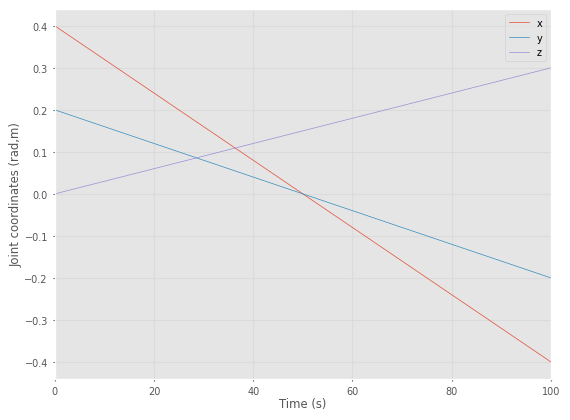

[<Axes: xlabel='Time (s)', ylabel='Joint coordinates (rad,m)'>]

In [145]:
rtb.xplot(P, labels="x y z")

and the orientation as roll-pitch-yaw angles

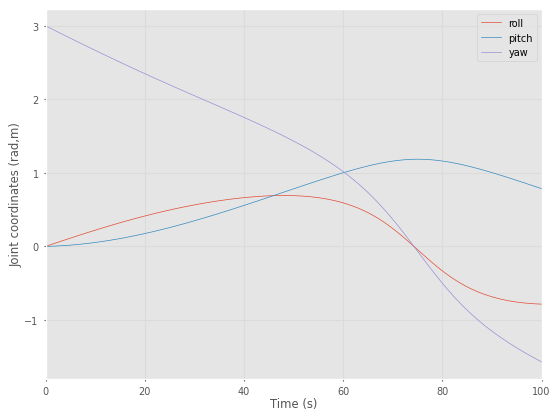

[<Axes: xlabel='Time (s)', ylabel='Joint coordinates (rad,m)'>]

In [146]:
rpy = Ts.rpy()
rtb.xplot(rpy, labels="roll pitch yaw")

We see that the position coordinates vary linearly with time, but that the roll-pitch-yaw angles are non-linear with time and that has two causes. Firstly, roll-pitch-yaw angles are a non-linear transformation of the linearly-varying quaternion orientation. Secondly, this particular trajectory passes very close to the roll-pitch-yaw singularity, at around steps 24 and 25, and a symptom of this is the rapid rate of change of roll-pitch-yaw angles around this point. The coordinate frame is not rotating faster at this point – you can verify that in the animation – the rotational parameters are changing very quickly, and this is a consequence of the particular representation.

However, the motion has a velocity and acceleration discontinuity at the first and last points. While the path is smooth in space, the distance $s$ along the path is not smooth in time. Speed along the path jumps from zero to some finite value and then drops to zero at the end – there is no initial acceleration or final deceleration. The scalar functions quintic and trapezoidal discussed earlier can be used to generate the interpolation variable s so that motion along the path is smooth. We can pass a vector of normalized distances along the path as the second argument to `interp`

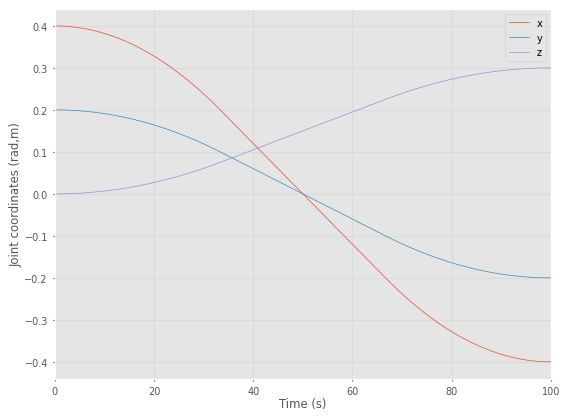

[<Axes: xlabel='Time (s)', ylabel='Joint coordinates (rad,m)'>]

In [155]:
Ts = T0.interp(T1, rtb.trapezoidal(0, 1, 101).q)
P = Ts.t
rtb.xplot(P, labels="x y z")

In [156]:
# Animate the trajectory
env = Swift()
env.launch(browser='notebook', realtime=True)
obj = sg.Axes(0.1)
env.add(obj)

env.set_camera_pose([0.1, 0.7, 0.3], [0.0, 0.0, 0.2])

for T in Ts:
    obj.T = T
    env.step(0.02)

The path is unchanged, but the coordinate frame now accelerates to a constant speed along the path and decelerates at the end, resulting in the smoother trajectories shown. The Toolbox provides a convenient shorthand `rtb.ctraj` function for this

In [157]:
Ts = rtb.ctraj(T0, T1, 101)

where the arguments are the initial and final pose and the number of time steps.